In [18]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Matern32_Model, Poisson_Model_T
%matplotlib inline


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
data = pd.read_csv('../data/gp_weekly_grid_parkslope.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data.DATE_IND = data.DATE_IND / 100
data.x_point = data.x_point #/ 100
data.y_point = data.y_point #/ 100

e_s = (5.36 / data.GRID_SQUARE.max()) # 5.36 is 2016 mean weekly crashes in park slope, divide by # squares
print(e_s)

0.111666666667


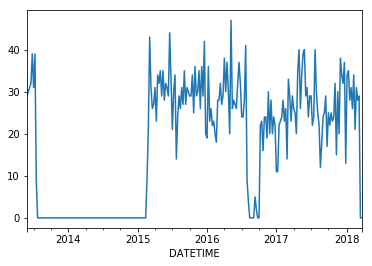

In [50]:
data.groupby('DATETIME')['COUNT'].sum().plot()

In [73]:
search_periods = [[52,12]]
                 

data.sort_values('DATETIME').head()


,Unnamed: 0,DATETIME,GRID_SQUARE,COUNT,x_point,y_point,DATE_IND
0,0,2013-06-02,1.0,0.0,8.556851,8.800599,0.01
252,1,2013-06-02,2.0,0.0,8.556851,8.675599,0.01
9072,36,2013-06-02,37.0,2.0,9.056851,8.300599,0.01
4032,16,2013-06-02,17.0,0.0,8.806851,8.800599,0.01
7812,31,2013-06-02,32.0,0.0,8.931851,7.925599,0.01


Beginning run [52, 12] : 
Training ends on: 2017-11-05 00:00:00
testing ends on: 2018-01-28 00:00:00
Initial neg. log-likelihood: -5527.78307415
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 1968.356363
  Number of iterations: 1501
  Number of functions evaluations: 1569
added gp pred and error to test
gp_sq_error    0.733974
0              0.774038
dtype: float64


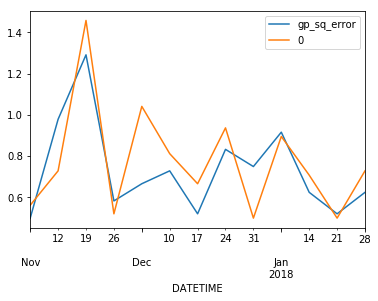

In [77]:
for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2016/11/6', training_end_date= s[0], \
                                                           testing_end_date=s[1])

    m = Poisson_Model_T(data_dict['X_train'],data_dict['y_train'],use_priors=False, e_s= e_s, period = 1)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 1500)
    
    u.pred_GP(m,data_dict)
    
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


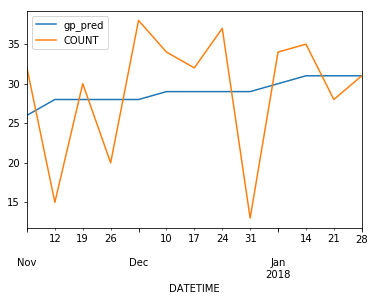

In [78]:
test.groupby('DATETIME')[['gp_pred','COUNT']].sum().plot()

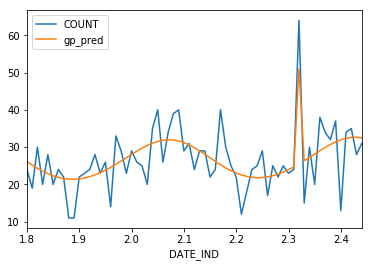

In [79]:
pred_train = m.predict_y(data_dict['X_train'])
pred_test = m.predict_y(data_dict['X_test'])

train = data_dict['train']
train['gp_pred'] = pred_train[0]
train['gp_var'] = pred_train[1]

test = data_dict['test']
test['gp_pred'] = pred_test[0]
test['gp_var'] = pred_test[1]


pred = train.append(test)#[['COUNT','gp_pred']]


pred.groupby('DATE_IND')[['COUNT','gp_pred']].sum().plot()

In [54]:
test[test.GRID_SQUARE == 33][['gp_pred','COUNT']]

,gp_pred,COUNT
DATETIME,,
2017-12-31,4.0,1.0
2018-01-07,4.0,4.0
2018-01-14,4.0,6.0
2018-01-21,4.0,3.0
2018-01-28,4.0,6.0
2018-02-04,4.0,5.0
2018-02-11,4.0,4.0
2018-02-18,4.0,3.0
2018-02-25,4.0,8.0
